# Bank Marketing Campaign Machine Learning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import category_encoders as ce

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer, f1_score, accuracy_score, recall_score, precision_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import time

## Business Problem Understanding

#### **Context**

The types of financial products used by the public are more varied. One financial product that is well-known to the public is term deposits. The term deposit mechanism is that a customer deposits a sum of money at a bank or a financial institution, and the money can only be withdrawn after a certain period of time. As compensation, customers will be given a fixed interest according to the nominal amount of money deposited.

Nevertheless, as business entities with financial products and respective customers, banks still have to compete to not lose customers. One of the ways to acquire new customers is by conducting a marketing campaign.

#### **Problem Statement**

Although term deposits remain a widely recognized and trusted financial product, Bank A still struggle to differentiate themselves in a competitive market. This raises the need to analyze how marketing campaigns can effectively attract new customers and influence their decision to choose a specific bank’s term deposit product.

#### **Goals**

- To develop a machine learning classification model that can accurately predict customers with a high likelihood of subscribing to a term deposit.

- To identify the most influential features that affect a customer’s decision to make a term deposit.

- To support the design of more effective and targeted marketing strategies for customer acquisition.

#### **Analytic Approach** (steps in conducting ML)

Data from Bank A’s previous marketing campaigns will be used to build the machine learning model. The analytical process consists of the following steps:

1. Data understanding and exploration

2. Data cleaning and preprocessing

3. Feature engineering and encoding of categorical variables

4. Model development using various classification algorithms

5. Model evaluation using cross-validation and appropriate metrics

6. Selection of the best-performing classification model for deployment

#### **Stakeholder**

**Investor**

The Bank Investors: benefit from improved campaign efficiency, higher conversion rates, and increased profitability

**User**

Business Development Team: prioritizes high-potential customers based on model predictions

#### **Metric Evaluation**

**F1-score** (a performance measure for classification models that balances two key components) is the evaluation metric that will be used in this analysis. The two key components are:

    - Precision: how accurately the model predicts customers who actually make a deposit.

    - Recall: how well the model identifies the majority of customers who truly make a deposit.

#### **5-point Business ML Goals (Summary)**

1. Improve customer targeting by identifying prospects with a high likelihood of subscribing to term deposits.

2. Reduce marketing costs by minimizing outreach to low-potential customers.

3. Increase campaign conversion rates through data-driven decision making.

4. Provide actionable insights into customer behavior and key influencing factors.

5. Support long-term business growth by integrating machine learning into marketing strategy planning.


## Data Understanding

In [3]:
df = pd.read_csv(r'C:\Users\Zea\Downloads\data_bank_marketing_campaign.csv')
df.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


This dataset has a total of 7,813 data with no null values.

#### Data Dictionary

| **Column Category**       | **Column**  | **Description**                                           |
|--------------------------|------------|---------------------------------------------------------|
| **Client Identifier**     | age       | The age of the client (int64)                                        |
|                          | job  | The job type of the client (object)                              |
|                          | balance      | The balance in the client's account (int64)                                         |
|                          | housing  | Does the client have a housing loan? (object)               |
|                          | loan   | Does the client have a loan? (object)                  |
| **Marketing Identifier**       | contact     | Contact communication type (object)                              |
|                          | month      | Last contact month of the year (object)                      |
|                          | campaign   | Number of contacts performed during this campaign and for this client (int64) |
|                          | pdays      | Number of days after the client was contacted from the previous campaign (int64) |
|                          | poutcome | Outcome of the previous marketing campaign (object)            |
|                          | deposit    | Whether the client deposits or not (object)         |

***Additional information***

- `balance` column: The feature can take negative values due to administrative fees, which may reduce a customer’s account balance below zero when the account balance is empty (zero) at the time the fees are applied.

- `pdays` column: -1 means that the client has not been contacted in previous marketing campaign.

- `poutcome` column description: 

    1. Success: The prospective client made a deposit after being contacted

    2. Failure: The prospective client did not make a deposit despite of being contacted

    3. Other: The prospective client did not answer the call when contacted

    4. Unknown: The prospective client has never been contacted before

The deposit column is the prediction target whereas the remaining columns are the features used to predict the target.

## Data Cleaning

In [5]:
# Checking the null values
df.isna().sum()

age         0
job         0
balance     0
housing     0
loan        0
contact     0
month       0
campaign    0
pdays       0
poutcome    0
deposit     0
dtype: int64

No missing values in the dataset.

#### Checking the unique values within the dataset

In [6]:
df['age'].unique()

array([55, 39, 51, 38, 36, 41, 37, 35, 57, 23, 33, 31, 53, 30, 46, 48, 25,
       29, 28, 52, 49, 44, 42, 27, 47, 64, 26, 34, 56, 32, 58, 45, 54, 50,
       79, 65, 40, 24, 60, 43, 61, 59, 62, 68, 82, 71, 73, 76, 69, 20, 72,
       22, 67, 19, 70, 75, 63, 93, 77, 80, 66, 21, 87, 81, 92, 88, 84, 83,
       78, 74, 18, 85, 95, 86, 90])

In [7]:
df['job'].unique()

array(['admin.', 'self-employed', 'services', 'housemaid', 'technician',
       'management', 'student', 'blue-collar', 'entrepreneur', 'retired',
       'unemployed', 'unknown'], dtype=object)

In [8]:
df['job'].value_counts()

job
management       1792
blue-collar      1346
technician       1291
admin.            936
services          658
retired           540
self-employed     280
unemployed        249
student           247
entrepreneur      236
housemaid         184
unknown            54
Name: count, dtype: int64

In [9]:
df['contact'].unique()

array(['cellular', 'telephone', 'unknown'], dtype=object)

In [10]:
df['contact'].value_counts()

contact
cellular     5628
unknown      1639
telephone     546
Name: count, dtype: int64

In [11]:
df['month'].unique()

array(['jun', 'apr', 'may', 'nov', 'jan', 'sep', 'feb', 'mar', 'aug',
       'jul', 'oct', 'dec'], dtype=object)

In [12]:
df['poutcome'].unique()

array(['unknown', 'other', 'failure', 'success'], dtype=object)

In [13]:
df['poutcome'].value_counts()

poutcome
unknown    5819
failure     848
success     761
other       385
Name: count, dtype: int64

In [14]:
# Checking the duplicated data
df.duplicated().sum()

np.int64(8)

In [15]:
display(df.duplicated().sum())

np.int64(8)

In [16]:
# Removing the duplicated data from the dataset
df = df.drop_duplicates()
df.shape

(7805, 11)

In [17]:
# Checking the values of pdays based on the poutcome
df.groupby('poutcome')['pdays'].value_counts()

poutcome  pdays
failure    92        14
           181       14
           91        13
           342       13
           182       12
                   ... 
success    651        1
           771        1
unknown   -1       5809
           98         1
           188        1
Name: count, Length: 742, dtype: int64

The outcomes of "unknown" should only have pdays of -1 since these clients are not contacted previously. This might be due to error in data entry, thus the positive pdays in the "unknown" column will be transformed into the "other" column.

In [18]:
# Transforming the values of poutcome
df['poutcome'] = np.where((df['pdays']>0) & (df['poutcome']=='unknown'), 'other', df['poutcome'])
df.groupby('poutcome')[['pdays']].value_counts()

poutcome  pdays
failure    92        14
           181       14
           91        13
           342       13
           182       12
                   ... 
success    472        1
           541        1
           651        1
           771        1
unknown   -1       5809
Name: count, Length: 740, dtype: int64

In [19]:
# Handling outlier
df.describe()

,age,balance,campaign,pdays
count,7805.000000,7805.000000,7805.000000,7805.000000
mean,41.257783,1513.968225,2.520564,51.462268
std,11.922833,3090.508938,2.728204,108.115084
min,18.000000,-6847.000000,1.000000,-1.000000
25%,32.000000,128.000000,1.000000,-1.000000
50%,39.000000,550.000000,2.000000,-1.000000
75%,49.000000,1685.000000,3.000000,41.000000
max,95.000000,66653.000000,63.000000,854.000000


In [20]:
# A typo in "admin" value of the "job" column
df["job"] = df["job"].str.replace(".","")
df["job"].unique()

array(['admin', 'self-employed', 'services', 'housemaid', 'technician',
       'management', 'student', 'blue-collar', 'entrepreneur', 'retired',
       'unemployed', 'unknown'], dtype=object)

## Data Analysis

#### 1. Numerical Features Distribution

Let's look at the data distribution

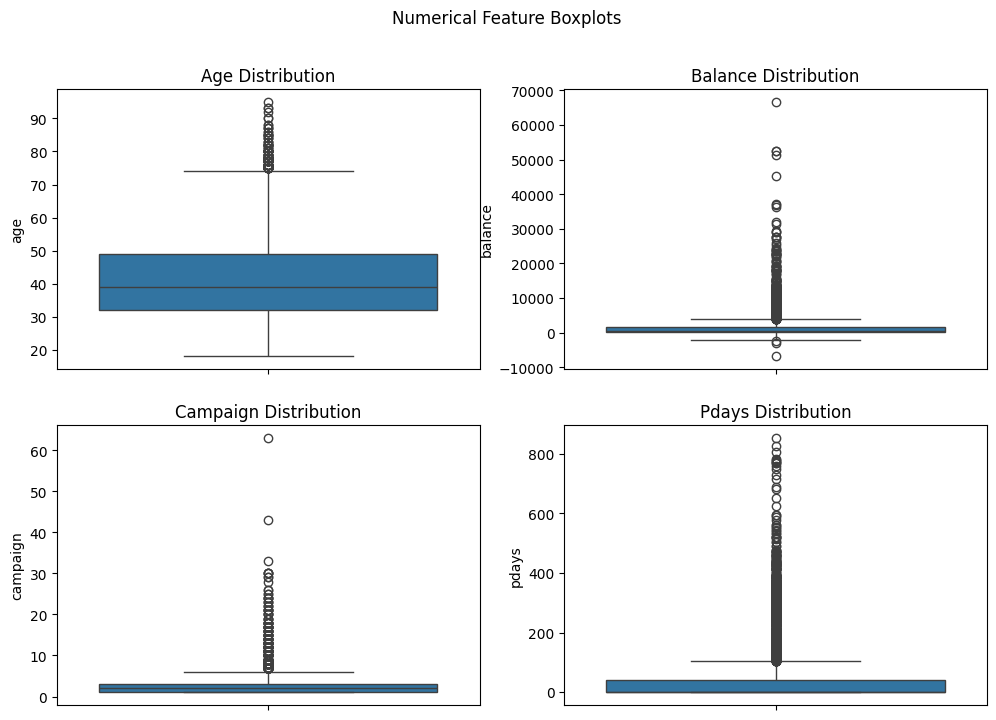

In [ ]:
# Box plot data
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sns.boxplot(df['age'])
plt.title('Age Distribution')

plt.subplot(2,2,2)
sns.boxplot(df['balance'])
plt.title('Balance Distribution')

plt.subplot(2,2,3)
sns.boxplot(df['campaign'])
plt.title('Campaign Distribution')

plt.subplot(2,2,4)
sns.boxplot(df['pdays'])
plt.title('Pdays Distribution')

plt.suptitle('Numerical Feature Boxplots')

plt.show()

Outliers present in campaign and balance data.

In [23]:
# IQR 1.5 calculation to check the outlier 
columns = ["age","balance","campaign","pdays"]
list_Q1 = []
list_Q3 = []
iqr_list= []
list_l_bound = []
list_u_bound = []
length_list = []
percentage_n_list =[]

for col in columns:
    Q3 = df[col].quantile(0.75)
    Q1 = df[col].quantile(0.25)
    IQR = Q3 - Q1
    u_bound = Q3 + 1.5*IQR
    l_bound = Q1 - 1.5*IQR
    length = len(df[(df[col] < l_bound) | (df[col] > u_bound) ])
    percentage_n = round(length/len(df),2)
    list_Q1.append(Q1)
    list_Q3.append(Q3)
    iqr_list.append(IQR)
    list_l_bound.append(l_bound)
    list_u_bound.append(u_bound)
    length_list.append(length)
    percentage_n_list.append(percentage_n)
df_IQR = pd.DataFrame({
    "columns":columns,
    "Q1":list_Q1,
    "Q3":list_Q3,
    "IQR":iqr_list,
    "Lower Bound":list_l_bound,
    "Upper Bound":list_u_bound,
    "n": length_list,
    "n(%)": percentage_n_list
})

df_IQR

,columns,Q1,Q3,IQR,Lower Bound,Upper Bound,n,n(%)
0,age,32.0,49.0,17.0,6.5,74.5,121,0.02
1,balance,128.0,1685.0,1557.0,-2207.5,4020.5,736,0.09
2,campaign,1.0,3.0,2.0,-2.0,6.0,429,0.05
3,pdays,-1.0,41.0,42.0,-64.0,104.0,1432,0.18


In [24]:
# IQR 3 calculation to check the outlier
columns = ["age","balance","campaign","pdays"]
list_Q1 = []
list_Q3 = []
iqr_list= []
list_l_bound = []
list_u_bound = []
length_list = []
percentage_n_list =[]

for col in columns:
    Q3 = df[col].quantile(0.75)
    Q1 = df[col].quantile(0.25)
    IQR = Q3 - Q1
    u_bound = Q3 + 3*IQR
    l_bound = Q1 - 3*IQR
    length = len(df[(df[col] < l_bound) | (df[col] > u_bound) ])
    percentage_n = round(length/len(df),2)
    list_Q1.append(Q1)
    list_Q3.append(Q3)
    iqr_list.append(IQR)
    list_l_bound.append(l_bound)
    list_u_bound.append(u_bound)
    length_list.append(length)
    percentage_n_list.append(percentage_n)
df_IQR = pd.DataFrame({
    "columns":columns,
    "Q1":list_Q1,
    "Q3":list_Q3,
    "IQR":iqr_list,
    "Lower Bound":list_l_bound,
    "Upper Bound":list_u_bound,
    "n": length_list,
    "n(%)": percentage_n_list
})

df_IQR

,columns,Q1,Q3,IQR,Lower Bound,Upper Bound,n,n(%)
0,age,32.0,49.0,17.0,-19.0,100.0,0,0.00
1,balance,128.0,1685.0,1557.0,-4543.0,6356.0,376,0.05
2,campaign,1.0,3.0,2.0,-5.0,9.0,190,0.02
3,pdays,-1.0,41.0,42.0,-127.0,167.0,1216,0.16


These outliers are better to be removed since the total outliers >30% (based on the IQR analysis) and it may disturb the model construction.

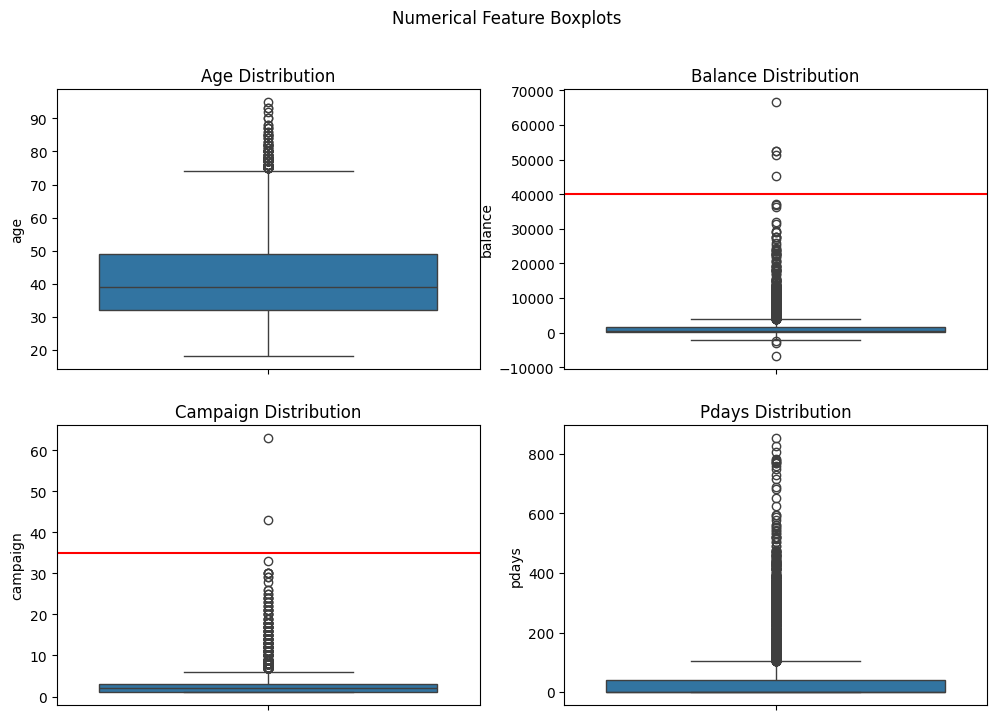

In [25]:
# Outlier visualisation
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sns.boxplot(df['age'])
plt.title('Age Distribution')

plt.subplot(2,2,2)
sns.boxplot(df['balance'])
plt.axhline(40000,c='r')
plt.title('Balance Distribution')

plt.subplot(2,2,3)
sns.boxplot(df['campaign'])
plt.axhline(35,c='r')
plt.title('Campaign Distribution')

plt.subplot(2,2,4)
sns.boxplot(df['pdays'])
plt.title('Pdays Distribution')

plt.suptitle('Numerical Feature Boxplots')

plt.show()

In [26]:
# Dropping outliers
df = df[df['balance']<40000]
df = df[df['campaign']<35]
df

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...
7808,62,housemaid,2,no,no,cellular,nov,1,-1,unknown,yes
7809,48,housemaid,5473,no,no,cellular,feb,2,184,success,yes
7810,36,unknown,179,no,no,cellular,aug,8,-1,unknown,no
7811,31,admin,54,yes,no,cellular,nov,1,-1,unknown,no


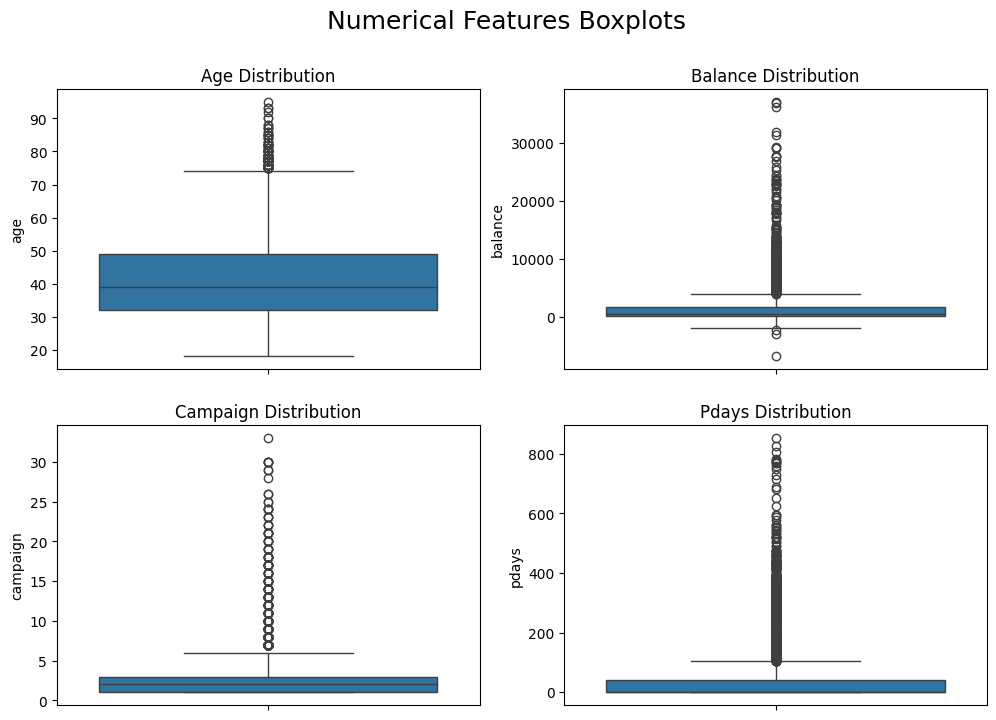

In [27]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sns.boxplot(df['age'])
plt.title('Age Distribution')

plt.subplot(2,2,2)
sns.boxplot(df['balance'])
plt.title('Balance Distribution')

plt.subplot(2,2,3)
sns.boxplot(df['campaign'])
plt.title('Campaign Distribution')

plt.subplot(2,2,4)
sns.boxplot(df['pdays'])
plt.title('Pdays Distribution')

plt.suptitle('Numerical Features Boxplots', fontsize=18)

plt.show()

In [28]:
df.describe()

,age,balance,campaign,pdays
count,7798.000000,7798.000000,7798.000000,7798.000000
mean,41.248012,1479.727622,2.508079,51.484996
std,11.921585,2787.976528,2.601807,108.142595
min,18.000000,-6847.000000,1.000000,-1.000000
25%,32.000000,128.000000,1.000000,-1.000000
50%,39.000000,549.000000,2.000000,-1.000000
75%,49.000000,1681.750000,3.000000,41.000000
max,95.000000,37127.000000,33.000000,854.000000


**Normality Test**

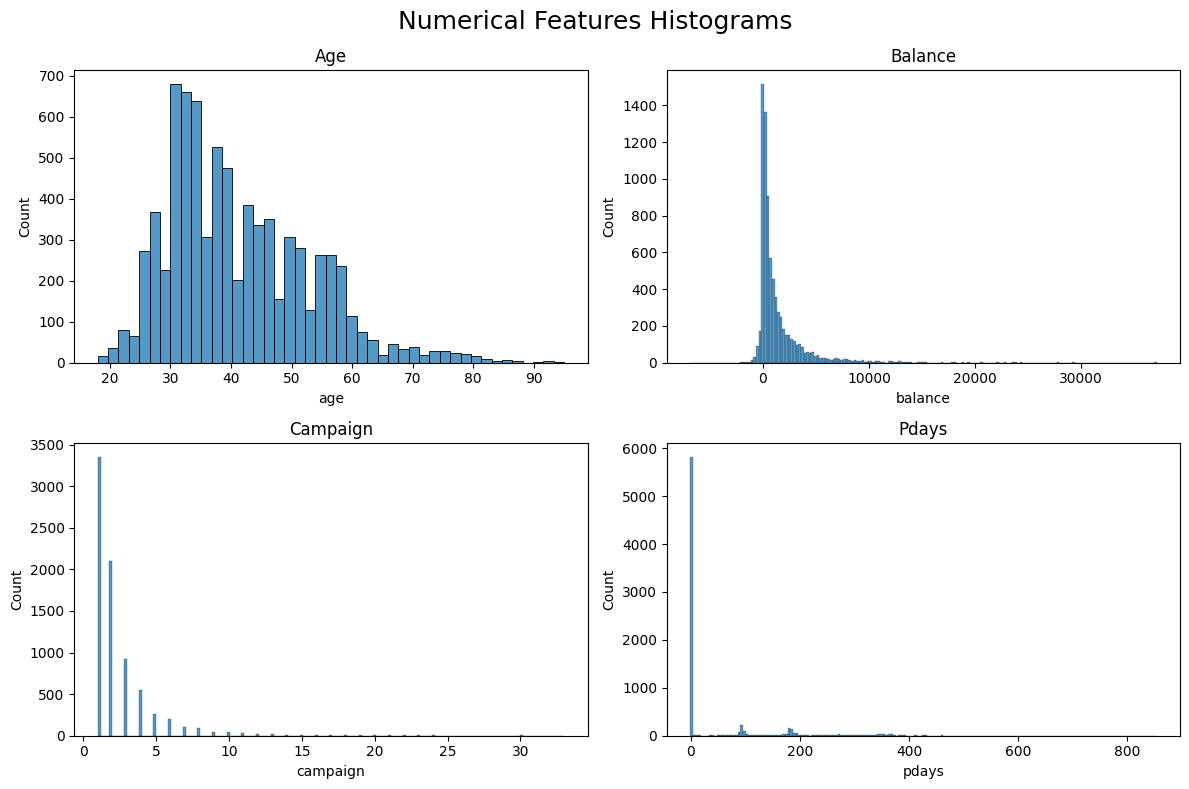

In [29]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sns.histplot(df['age'])
plt.title('Age')

plt.subplot(2,2,2)
sns.histplot(df['balance'])
plt.title('Balance')

plt.subplot(2,2,3)
sns.histplot(df['campaign'])
plt.title('Campaign')

plt.subplot(2,2,4)
sns.histplot(df['pdays'])
plt.title('Pdays')

plt.suptitle('Numerical Features Histograms', fontsize=18)
plt.tight_layout()
plt.show()

In [30]:
from scipy.stats import normaltest

normality = df.select_dtypes(include='number').apply(lambda col: normaltest(col.dropna())[1]).reset_index()
normality.columns = ['Column', 'P-value']
normality

,Column,P-value
0,age,3.311102e-179
1,balance,0.000000e+00
2,campaign,0.000000e+00
3,pdays,0.000000e+00


In [31]:
normality[normality['P-value']<=0.05]['Column'].unique()

array(['age', 'balance', 'campaign', 'pdays'], dtype=object)

Data distribution is not normal, thus these features need to be treated with scaling robust to promote more consistent data.

#### Imbalance Detection

In [32]:
majority = df['deposit'].value_counts().max()
minority = df['deposit'].value_counts().min()
ratio = majority / minority
print(majority, minority)
print("Imbalance ratio:", ratio)

4071 3727
Imbalance ratio: 1.0922994365441374


- The dataset ratio is 1.09:1, and this means that the data is leaning towards balanced.

- We can rely on accuracy, F1-score, ROC-AUC normally.

#### 2. Categorical Features Distribution

In [33]:
df.describe(include=['O'])

,job,housing,loan,contact,month,poutcome,deposit
count,7798,7798,7798,7798,7798,7798,7798
unique,12,2,2,3,12,4,2
top,management,no,no,cellular,may,unknown,no
freq,1788,4132,6775,5619,1971,5803,4071


In [34]:
df['job'].unique()

array(['admin', 'self-employed', 'services', 'housemaid', 'technician',
       'management', 'student', 'blue-collar', 'entrepreneur', 'retired',
       'unemployed', 'unknown'], dtype=object)

In [35]:
df['month'].unique()

array(['jun', 'apr', 'may', 'nov', 'jan', 'sep', 'feb', 'mar', 'aug',
       'jul', 'oct', 'dec'], dtype=object)

In [36]:
df['contact'].unique()

array(['cellular', 'telephone', 'unknown'], dtype=object)

In [37]:
df[(df['loan'] == 'yes')]['deposit'].value_counts()

deposit
no     693
yes    330
Name: count, dtype: int64

In [38]:
df[(df['housing'] == 'yes')]['deposit'].value_counts()

deposit
no     2325
yes    1341
Name: count, dtype: int64

In [39]:
df[(df['poutcome'] == 'success') | (df['poutcome'] == 'failure') | (df['poutcome'] == 'unknown') | (df['poutcome'] == 'other')]['deposit'].value_counts()

deposit
no     4071
yes    3727
Name: count, dtype: int64

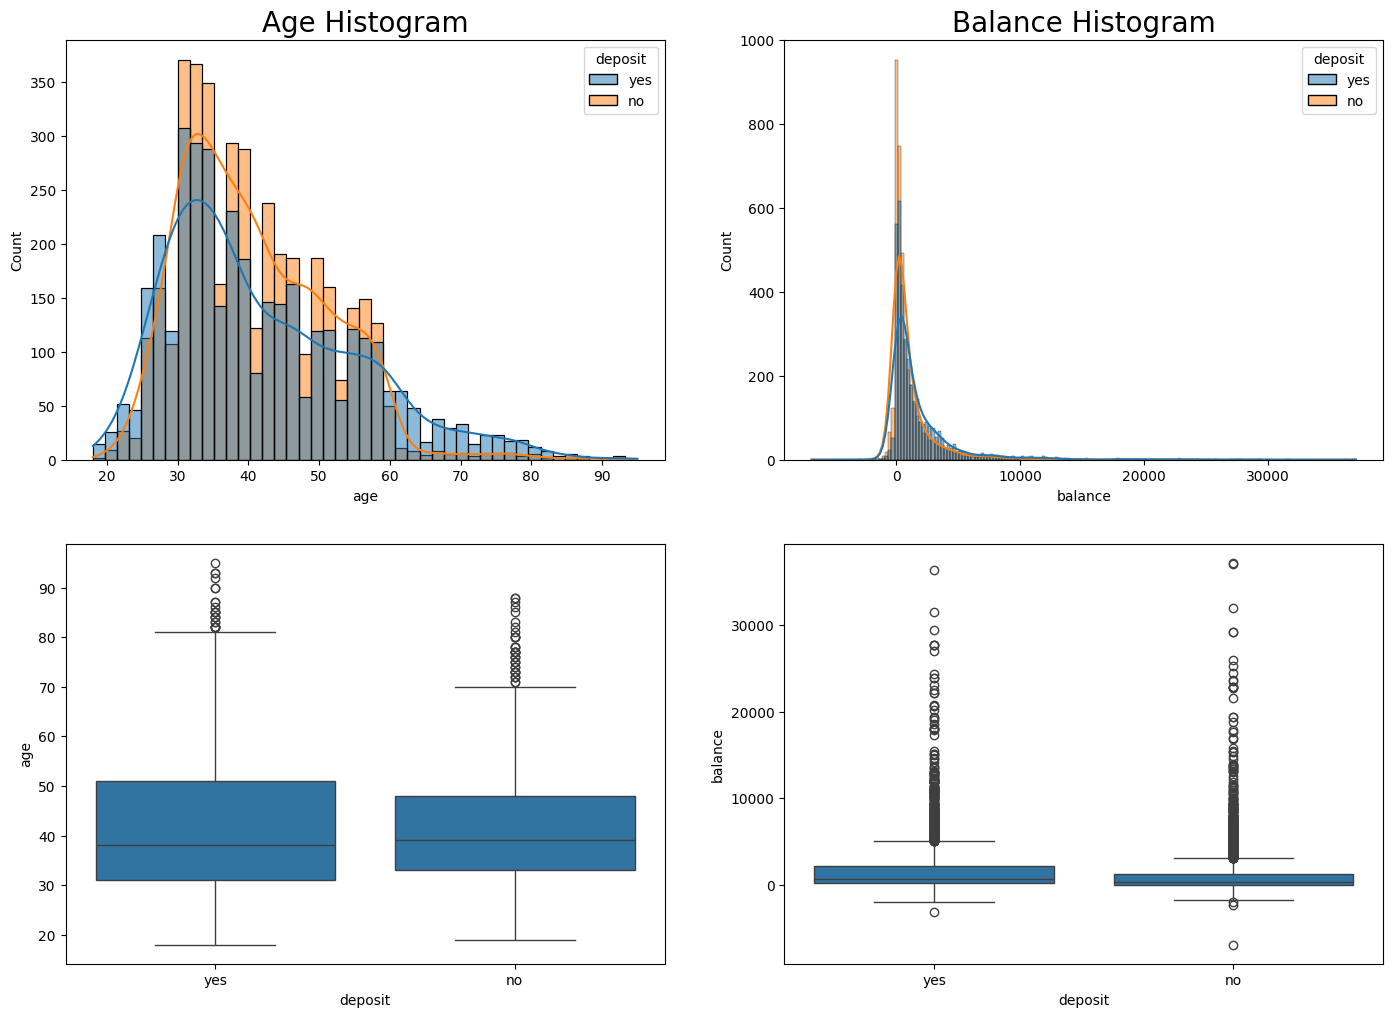

In [40]:
plt.figure(figsize=(17,12))

plt.subplot(221)
sns.histplot(data=df,x='age',hue='deposit',kde=True)
plt.title('Age Histogram',fontsize=20)

plt.subplot(222)
sns.histplot(data=df,x='balance',hue='deposit',kde=True)
plt.title('Balance Histogram',fontsize=20)

plt.subplot(223)
sns.boxplot(data=df,y='age', x='deposit')

plt.subplot(224)
sns.boxplot(data=df,y='balance', x='deposit')
plt.show()

From the histogram and boxplot above, we can conclude that `age` has a different distribution towards the deposit, where target = deposit (1) is higher than then the no deposit (0).

Moreover, `balance` distribution is has a slight difference between the target.

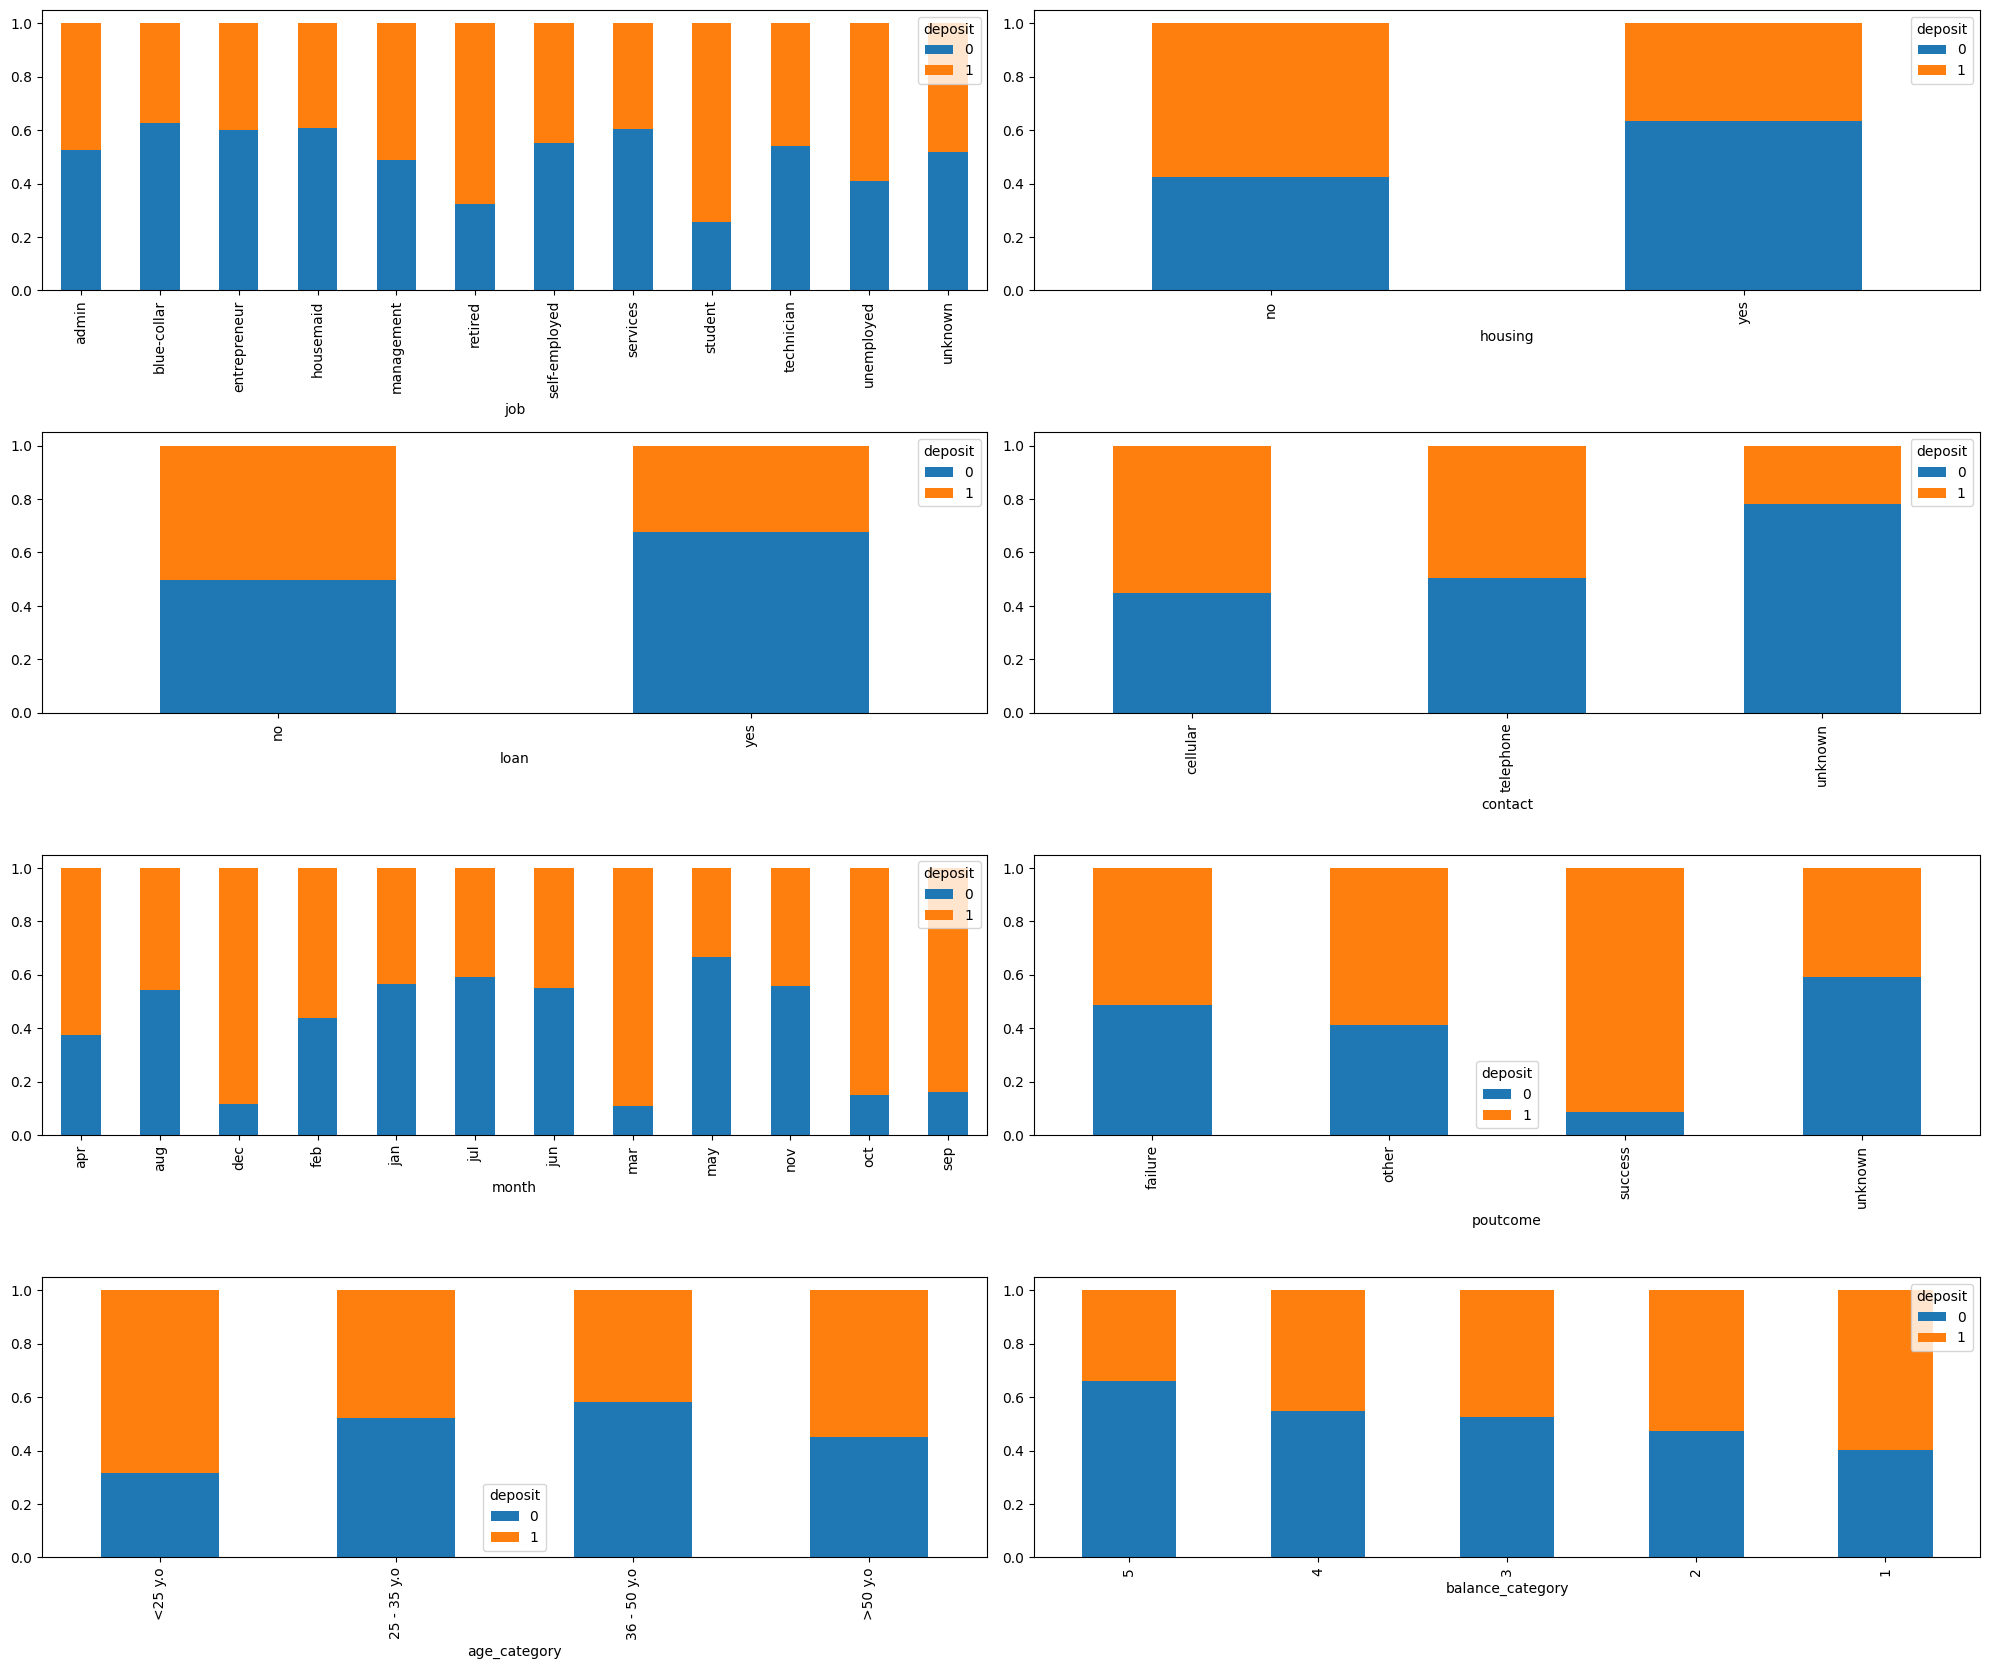

In [96]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df.drop(columns=['deposit','age', 'balance', 'campaign', 'pdays']).columns:
    count +=1
    ax= plt.subplot(5,2,count)
    pd.crosstab(df[i],df['deposit'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

In [42]:
for i in df.drop(columns=['deposit','age','balance']).columns:
    relevent_experience_df = df.groupby(i)['deposit'].value_counts(normalize=True).unstack()
    display(relevent_experience_df.sort_values(by=['yes'], ascending=False))

deposit,no,yes
job,,
student,0.255061,0.744939
retired,0.324074,0.675926
unemployed,0.409639,0.590361
management,0.489374,0.510626
unknown,0.518519,0.481481
admin,0.525641,0.474359
technician,0.538820,0.461180
self-employed,0.550360,0.449640
entrepreneur,0.600000,0.400000


deposit,no,yes
housing,,
no,0.422556,0.577444
yes,0.634206,0.365794


deposit,no,yes
loan,,
no,0.498598,0.501402
yes,0.677419,0.322581


deposit,no,yes
contact,,
cellular,0.448834,0.551166
telephone,0.504587,0.495413
unknown,0.779682,0.220318


deposit,no,yes
month,,
mar,0.110553,0.889447
dec,0.117647,0.882353
oct,0.150350,0.849650
sep,0.160377,0.839623
apr,0.373112,0.626888
feb,0.437148,0.562852
aug,0.542169,0.457831
jun,0.550758,0.449242
nov,0.558600,0.441400


deposit,no,yes
campaign,,
1,0.463859,0.536141
29,0.500000,0.500000
2,0.530894,0.469106
3,0.533188,0.466812
4,0.562044,0.437956
14,0.600000,0.400000
7,0.621359,0.378641
5,0.625000,0.375000
15,0.625000,0.375000


deposit,no,yes
pdays,,
29,NaN,1.0
854,NaN,1.0
551,NaN,1.0
555,NaN,1.0
561,NaN,1.0
...,...,...
651,1.0,NaN
717,1.0,NaN
771,1.0,NaN


deposit,no,yes
poutcome,,
success,0.085526,0.914474
other,0.410853,0.589147
failure,0.487028,0.512972
unknown,0.591763,0.408237


**Summary:**

1. Clients that are students (`job`) tend to make a deposit than other professions.

2. Clients that have no `housing` tend to make a deposit than clients that have `housing`.

3. Clients that have no `loan` tend make a deposit than clients with loans.

4. Clients that are contacted through celullar are inclined to make deposits than other types of `contact`.

5. Clients are heavily interested in making deposits during the `month` of March.

5. Clients after the 1st time of `campaign` tend to make the deposits than other amount of campaigns.

6. Clients that are last contacted after 29 days tend to make deposits based on the `pdays`.

7. Most of the `poutcome` are successful.

In [43]:
age_pattern_df = df.groupby('age')['deposit'].value_counts(normalize=True).unstack()
age_pattern_df['count'] = df.groupby('age')['deposit'].count()
display(age_pattern_df.sort_values(by=['yes'], ascending=False).head(15))
display(age_pattern_df.sort_values(by=['yes'], ascending=False).tail(15))

deposit,no,yes,count
age,,,
18,NaN,1.000000,6
90,NaN,1.000000,2
92,NaN,1.000000,1
79,NaN,1.000000,7
95,NaN,1.000000,1
93,NaN,1.000000,2
84,NaN,1.000000,3
64,0.071429,0.928571,28
71,0.090909,0.909091,22


deposit,no,yes,count
age,,,
52,0.570423,0.429577,142
51,0.572464,0.427536,138
53,0.573643,0.426357,129
56,0.576000,0.424000,125
38,0.580769,0.419231,260
44,0.580838,0.419162,167
31,0.581197,0.418803,351
39,0.587045,0.412955,247
49,0.601156,0.398844,173


In [44]:
df['age'].value_counts()

age
31    351
32    344
30    328
35    324
33    317
     ... 
88      2
90      2
86      2
92      1
95      1
Name: count, Length: 75, dtype: int64

In [45]:
age_pattern_df.sort_values(by=['yes'], ascending=False).loc[31]

deposit
no         0.581197
yes        0.418803
count    351.000000
Name: 31, dtype: float64

In [46]:
age_pattern_df.sort_values(by=['yes'], ascending=False).loc[32]

deposit
no         0.543605
yes        0.456395
count    344.000000
Name: 32, dtype: float64

In [47]:
age_pattern_df.sort_values(by=['yes'], ascending=False).loc[30]

deposit
no         0.509146
yes        0.490854
count    328.000000
Name: 30, dtype: float64

In [48]:
age_pattern_df.sort_values(by=['yes'], ascending=False).loc[35]

deposit
no         0.54321
yes        0.45679
count    324.00000
Name: 35, dtype: float64

In [49]:
age_pattern_df.sort_values(by=['yes'], ascending=False).loc[33]

deposit
no         0.567823
yes        0.432177
count    317.000000
Name: 33, dtype: float64

It can be seen from the top 5 clients based on the age distribution that they have a similar pattern which tells us about these clients do not make deposits.

## Feature Engineering

We can make new features that are beneficial in machine learning modelling.

#### 1. Bin Age

This feature is made to give the clients age categorization and which age range they fall into.

- < 25 y.o: Entry-level earners

- 25 - 35 y.o: Early career and building savings

- 36 - 50 y.o: High earning and high deposit probability

- > 50 y.o: Retirement and long-term savings

In [50]:
df['age_category']=pd.cut(df['age'],bins=[0, 25, 35, 50, float('inf')],labels=['<25 y.o', '25 - 35 y.o', '36 - 50 y.o', '>50 y.o'])
df.head(10)

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit,age_category
0,55,admin,1662,no,no,cellular,jun,2,-1,unknown,yes,>50 y.o
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes,36 - 50 y.o
2,51,admin,3025,no,no,cellular,may,1,352,other,yes,>50 y.o
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no,36 - 50 y.o
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no,36 - 50 y.o
5,41,admin,-76,yes,no,cellular,apr,1,-1,unknown,no,36 - 50 y.o
6,37,admin,4803,no,no,cellular,jan,2,-1,unknown,yes,36 - 50 y.o
7,36,technician,911,yes,yes,cellular,may,2,21,failure,yes,36 - 50 y.o
8,35,management,805,no,no,cellular,sep,1,-1,unknown,no,25 - 35 y.o
9,57,housemaid,0,no,no,unknown,jun,1,-1,unknown,no,>50 y.o


In [51]:
df['age_category']=pd.cut(df['age'],bins=[0, 25, 35, 50, float('inf')],labels=['<25 y.o', '25 - 35 y.o', '36 - 50 y.o', '>50 y.o'])
df.head(10)

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit,age_category
0,55,admin,1662,no,no,cellular,jun,2,-1,unknown,yes,>50 y.o
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes,36 - 50 y.o
2,51,admin,3025,no,no,cellular,may,1,352,other,yes,>50 y.o
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no,36 - 50 y.o
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no,36 - 50 y.o
5,41,admin,-76,yes,no,cellular,apr,1,-1,unknown,no,36 - 50 y.o
6,37,admin,4803,no,no,cellular,jan,2,-1,unknown,yes,36 - 50 y.o
7,36,technician,911,yes,yes,cellular,may,2,21,failure,yes,36 - 50 y.o
8,35,management,805,no,no,cellular,sep,1,-1,unknown,no,25 - 35 y.o
9,57,housemaid,0,no,no,unknown,jun,1,-1,unknown,no,>50 y.o


In [52]:
age_category=list(df['age_category'].unique().categories)
age_category

['<25 y.o', '25 - 35 y.o', '36 - 50 y.o', '>50 y.o']

In [53]:
df['age_category'].value_counts()

age_category
36 - 50 y.o    3038
25 - 35 y.o    2732
>50 y.o        1721
<25 y.o         307
Name: count, dtype: int64

#### 2. Bin Balance

This feature is made to give the clients balance categorization based on their account balance (in USD).

- 5: <0 - 67.0

- 4: 67.0 - 337.0

- 3: 337.0 - 855.0

- 2: 855.0, 2161.0

- 1: >2161

In [54]:
# Transforming the top and bottom balance interval
balance_category=list(pd.qcut(df['balance'],5).unique().categories)

balance_category[0] = pd.Interval(left=-float('inf'), right=balance_category[0].right, closed='right')

balance_category[-1] = pd.Interval(left=balance_category[-1].left, right=float('inf'), closed='right')
balance_category

[Interval(-inf, np.float64(67.0), closed='right'),
 Interval(67.0, 337.0, closed='right'),
 Interval(337.0, 855.0, closed='right'),
 Interval(855.0, 2161.0, closed='right'),
 Interval(2161.0, inf, closed='right')]

In [55]:
label = ['A', 'B', 'C', 'D', 'E']
df['balance_category'] = pd.cut(df['balance'], bins=balance_category, labels=label)
df

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit,age_category,balance_category
0,55,admin,1662,no,no,cellular,jun,2,-1,unknown,yes,>50 y.o,"(855.0, 2161.0]"
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes,36 - 50 y.o,"(-inf, 67.0]"
2,51,admin,3025,no,no,cellular,may,1,352,other,yes,>50 y.o,"(2161.0, inf]"
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no,36 - 50 y.o,"(-inf, 67.0]"
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no,36 - 50 y.o,"(67.0, 337.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7808,62,housemaid,2,no,no,cellular,nov,1,-1,unknown,yes,>50 y.o,"(-inf, 67.0]"
7809,48,housemaid,5473,no,no,cellular,feb,2,184,success,yes,36 - 50 y.o,"(2161.0, inf]"
7810,36,unknown,179,no,no,cellular,aug,8,-1,unknown,no,36 - 50 y.o,"(67.0, 337.0]"
7811,31,admin,54,yes,no,cellular,nov,1,-1,unknown,no,25 - 35 y.o,"(-inf, 67.0]"


In [56]:
df['balance_category'] = df['balance_category'].cat.rename_categories({
    pd.Interval(-np.inf, np.float64(67.0), closed='right'): '5',
    pd.Interval(67.0, 337.0, closed='right'): '4',
    pd.Interval(337.0, 855.0, closed='right'): '3',
    pd.Interval(855.0, 2161.0, closed='right'): '2',
    pd.Interval(2161.0, np.inf, closed='right'): '1'
})
df

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit,age_category,balance_category
0,55,admin,1662,no,no,cellular,jun,2,-1,unknown,yes,>50 y.o,2
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes,36 - 50 y.o,5
2,51,admin,3025,no,no,cellular,may,1,352,other,yes,>50 y.o,1
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no,36 - 50 y.o,5
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no,36 - 50 y.o,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7808,62,housemaid,2,no,no,cellular,nov,1,-1,unknown,yes,>50 y.o,5
7809,48,housemaid,5473,no,no,cellular,feb,2,184,success,yes,36 - 50 y.o,1
7810,36,unknown,179,no,no,cellular,aug,8,-1,unknown,no,36 - 50 y.o,4
7811,31,admin,54,yes,no,cellular,nov,1,-1,unknown,no,25 - 35 y.o,5


In [57]:
df['balance_category'].value_counts()

balance_category
5    1567
3    1561
1    1559
2    1556
4    1555
Name: count, dtype: int64

## Data Preparation

**Features Encoding**

1. `job`: One Hot Encoding

2. `housing`: Binary Encoding

3. `loan`: Binary Encoding

4. `contact`: One Hot Encoding

5. `month`: One Hot Encoding

6. `poutcome`: One Hot Encoding

7. `age_category`: Ordinal Encoding

8. `balance_category`: Ordinal Encoding

In [58]:
for i in df.select_dtypes(object).columns:
    display(pd.DataFrame(df[i].value_counts()))

,count
job,
management,1788
blue-collar,1341
technician,1288
admin,936
services,658
retired,540
self-employed,278
unemployed,249
student,247


,count
housing,
no,4132
yes,3666


,count
loan,
no,6775
yes,1023


,count
contact,
cellular,5619
unknown,1634
telephone,545


,count
month,
may,1971
aug,1079
jul,1047
jun,857
apr,662
nov,657
feb,533
oct,286
jan,227


,count
poutcome,
unknown,5803
failure,848
success,760
other,387


,count
deposit,
no,4071
yes,3727


In [59]:
X = df.drop("deposit",axis=1)
y = df["deposit"]

In [60]:
# Splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=2020)
display(X_train.shape,X_test.shape)

(6238, 12)

(1560, 12)

In [61]:
df['deposit'] = df['deposit'].map({'no': 0, 'yes': 1})

In [62]:
df.reset_index(drop=True,inplace=True)
X_train = df.drop("deposit",axis=1)
y_train = df["deposit"]

X_test = df.drop("deposit",axis=1)
y_test = df["deposit"]

In [63]:
class MonthLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_dict = {
            'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
            'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
        }
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(lambda x: x.map(self.label_dict))

    def get_feature_names_out(self, input_features):
        return input_features

In [64]:
onehot_features = ['job', 'contact', 'poutcome']
binary_features = ['housing', 'loan']
ordinal_age_features = ['age_category']
ordinal_balance_features = ['balance_category']
numeric_features = ['age', 'balance', 'campaign', 'pdays']

In [65]:
# Data encoder
onehot = OneHotEncoder(handle_unknown='ignore')
binary = ce.BinaryEncoder()
ordinal_age = OrdinalEncoder(categories=[['<25 y.o', '25 - 35 y.o', '36 - 50 y.o', '>50 y.o']])
ordinal_balance = OrdinalEncoder(categories=[['1','2','3','4','5']])

# Numeric tranformation
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

In [66]:
transformer = ColumnTransformer(
    transformers=[
        ('onehot', onehot, onehot_features),
        ('binary', binary, binary_features),
        ('ordinal_age', ordinal_age, ordinal_age_features),
        ('ordinal_balance', ordinal_balance, ordinal_balance_features),
        ('num', numeric_transformer, numeric_features),
        ('month_encoder', MonthLabelEncoder(), ['month'])
    ]
)

## Modeling

The models that we're using: 

`Random Forest`, `Decision Tree`, `Logistic Regression`, and Gradient Boost (`XGBoost` and `LightGBM`)

In [67]:
pipeline = Pipeline(steps=[
    ('preprocessor', transformer),
    ('classifier', RandomForestClassifier())  # Placeholder for classifier
])

param_grid = [
    {
        'classifier': [RandomForestClassifier(random_state=42),
                       DecisionTreeClassifier(random_state=42),
                       LogisticRegression(random_state=42),
                       XGBClassifier(random_state=42),
                       lgb.LGBMClassifier(random_state=42)]
    },
]

In [68]:
# Checking the train data
print(X_train.columns.tolist())


['age', 'job', 'balance', 'housing', 'loan', 'contact', 'month', 'campaign', 'pdays', 'poutcome', 'age_category', 'balance_category']


In [69]:
# GridSearchCV with pipeline
gscv = GridSearchCV(
    pipeline,
    param_grid, 
    cv=5, 
    scoring=make_scorer(f1_score, pos_label=1), 
    n_jobs=-1, 
    error_score="raise")

# Measure the fitting time
start_time = time.time()


# Fit GridSearchCV ke data
gscv.fit(X_train, y_train)


end_time = time.time()

fitting_time = end_time - start_time
print(f"Fitting time: {fitting_time:.2f} seconds")

[LightGBM] [Info] Number of positive: 3727, number of negative: 4071
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 7798, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477943 -> initscore=-0.088285
[LightGBM] [Info] Start training from score -0.088285
Fitting time: 28.84 seconds


### Model Benchmarking (K-Fold)

In [70]:
logreg = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()

In [71]:
models = [logreg, dt, rf, xgb, lgbm]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']

scores = []
means = []
stds = []

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model in models:
    estimator = Pipeline([
        ('preprocess', transformer),
        ('model', model)
    ])

    cv_score = cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv=skfold, 
        scoring='roc_auc'
    )

    scores.append(cv_score)
    means.append(cv_score.mean())
    stds.append(cv_score.std())

pd.DataFrame({
    'Model': model_names,
    'Mean ROC-AUC': means,
    'Std Dev': stds
}).set_index('Model').sort_values('Mean ROC-AUC', ascending=False)


c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-le

[LightGBM] [Info] Number of positive: 2981, number of negative: 3257
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 6238, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477878 -> initscore=-0.088548
[LightGBM] [Info] Start training from score -0.088548


c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2981, number of negative: 3257
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 6238, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477878 -> initscore=-0.088548
[LightGBM] [Info] Start training from score -0.088548


c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2982, number of negative: 3256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 6238, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.478038 -> initscore=-0.087905
[LightGBM] [Info] Start training from score -0.087905


c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2982, number of negative: 3257
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 6239, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477961 -> initscore=-0.088212
[LightGBM] [Info] Start training from score -0.088212


c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2982, number of negative: 3257
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 670
[LightGBM] [Info] Number of data points in the train set: 6239, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477961 -> initscore=-0.088212
[LightGBM] [Info] Start training from score -0.088212


c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Mean ROC-AUC,Std Dev
Model,,
LightGBM,0.773026,0.009576
XGBoost,0.756362,0.006485
Random Forest,0.750938,0.010119
Logistic Regression,0.747458,0.013079
Decision Tree,0.627585,0.012931


`LightGBM` is the best model based on the ROC_AUC.

### Model Benchmarking (Test Data)

In [72]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for model, name in zip(
    models,
    ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']
):
    estimator = Pipeline([
        ('preprocess', transformer),
        ('model', model)
    ])
    
    f1_scores = cross_val_score(
        estimator,
        X_train,
        y_train,
        cv=cv,
        scoring='f1'
    )
    
    results.append({
        'model': name,
        'mean F1': f1_scores.mean(),
        'std F1': f1_scores.std()
    })

df_benchmark = (
    pd.DataFrame(results)
    .set_index('model')
    .sort_values(by='mean F1', ascending=False)
)

df_benchmark

c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-le

[LightGBM] [Info] Number of positive: 2981, number of negative: 3257
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 6238, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477878 -> initscore=-0.088548
[LightGBM] [Info] Start training from score -0.088548


c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2981, number of negative: 3257
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 6238, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477878 -> initscore=-0.088548
[LightGBM] [Info] Start training from score -0.088548


c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2982, number of negative: 3256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 6238, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.478038 -> initscore=-0.087905
[LightGBM] [Info] Start training from score -0.087905


c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2982, number of negative: 3257
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 6239, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477961 -> initscore=-0.088212
[LightGBM] [Info] Start training from score -0.088212


c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2982, number of negative: 3257
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 670
[LightGBM] [Info] Number of data points in the train set: 6239, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477961 -> initscore=-0.088212
[LightGBM] [Info] Start training from score -0.088212


c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,mean F1,std F1
model,,
LightGBM,0.678220,0.007631
XGBoost,0.667026,0.006353
Random Forest,0.661752,0.012046
Logistic Regression,0.657117,0.013555
Decision Tree,0.615113,0.007481


`LightGBM` has the highest F1 mean from this benchmarking.

### Evaluation Metrics

In [73]:
train_errors = []
validation_errors = []

def calc_train_error(X_train, y_train, model):
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1,  
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_validation_error(X_test, y_test, model):
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1,  
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error


In [74]:
K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

data = X_train
target = y_train

In [75]:
print(X_train)

      age            job  balance housing loan    contact month  campaign  \
0      55          admin     1662      no   no   cellular   jun         2   
1      39  self-employed    -3058     yes  yes   cellular   apr         3   
2      51          admin     3025      no   no   cellular   may         1   
3      38       services      -87     yes   no   cellular   may         1   
4      36      housemaid      205     yes   no  telephone   nov         4   
...   ...            ...      ...     ...  ...        ...   ...       ...   
7793   62      housemaid        2      no   no   cellular   nov         1   
7794   48      housemaid     5473      no   no   cellular   feb         2   
7795   36        unknown      179      no   no   cellular   aug         8   
7796   31          admin       54     yes   no   cellular   nov         1   
7797   60        retired     1588      no   no   cellular   oct         1   

      pdays poutcome age_category balance_category  
0        -1  unknown  

In [76]:
train_errors = []
validation_errors = []

for train_index, val_index in kf.split(data, target):
    
    # split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    Y_train, Y_val = target.iloc[train_index], target.iloc[val_index]

    # model
    lgbm = lgb.LGBMClassifier()
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',lgbm)
    ])

train_error, validation_error = calc_metrics(X_train, Y_train, X_val, Y_val, estimator)

train_errors.append(train_error)
validation_errors.append(validation_error)

[LightGBM] [Info] Number of positive: 3355, number of negative: 3664
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 7019, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477988 -> initscore=-0.088104
[LightGBM] [Info] Start training from score -0.088104


c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [77]:
listItem = []

for tr,val in zip(train_errors, validation_errors) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy',  
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.803391,0.721438,0.800022,0.716383,0.70462,0.615591,0.8587,0.755776
Average,0.803391,0.721438,0.800022,0.716383,0.70462,0.615591,0.8587,0.755776


#### Classification Reports

In [78]:
for rep in validation_errors:
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.70      0.82      0.75       407
           1       0.76      0.62      0.68       372

    accuracy                           0.72       779
   macro avg       0.73      0.72      0.72       779
weighted avg       0.73      0.72      0.72       779



The classification reports from `validation_errors` represent the model’s true performance on unseen data. The precision, recall, and f1-score show a reasonably good result.

### Hyperparameter Tuning

In [79]:
lgbm = lgb.LGBMClassifier()

estimator=Pipeline([
    ('preprocess',transformer),
    ('model',lgbm)
])

In [80]:
hyperparam_space = {
    'model__n_estimators': [300, 500],
    'model__learning_rate': [0.05, 0.1],
    'model__num_leaves': [31, 63],
    'model__max_depth': [-1, 10],
    'model__min_child_samples': [5, 10],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}


default hyperparameter LGBM => `max_bin` = 255, `num_leaves` = 31, `min_data_in_leaf` = 20, `num_iterations` = 100, `learning_rate` = 0.1

In [81]:
grid = GridSearchCV(
    estimator=estimator,
    param_grid=hyperparam_space,
    scoring='f1',
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    n_jobs=-1,
    refit=True
)


In [82]:
grid.fit(X_train,Y_train)
print(grid.best_score_)
print(grid.best_params_)

[LightGBM] [Info] Number of positive: 3355, number of negative: 3664
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 7019, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477988 -> initscore=-0.088104
[LightGBM] [Info] Start training from score -0.088104
0.6801430741364991
{'model__colsample_bytree': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 10, 'model__min_child_samples': 5, 'model__n_estimators': 300, 'model__num_leaves': 31, 'model__subsample': 0.8}


`num_leaves`: 31, `learning_rate`: 0.05, `max_depth`: 10, `min_child_samples`: 5, `n_estimators`: 300, `subsample`: 0.8

In [83]:
best_model = grid.best_estimator_
best_model.fit(X_train, Y_train)

[LightGBM] [Info] Number of positive: 3355, number of negative: 3664
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 7019, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477988 -> initscore=-0.088104
[LightGBM] [Info] Start training from score -0.088104


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('binary', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


#### Threshold Tuning

This step is done to ensure that the model’s predictions align optimally with both performance metrics and business objectives.

Moreover, this enables the optimization of the F1-score, which is the primary evaluation metric used in this analysis, as it balances precision and recall since the default threshold (0.5) does not necessarily produce the best balance.

c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


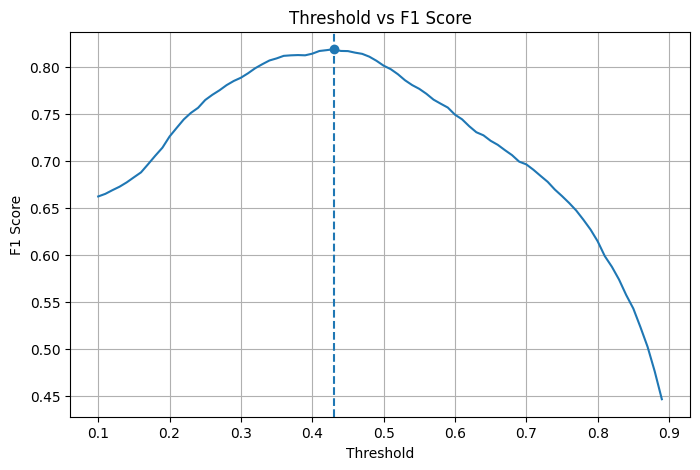

Best threshold: 0.4299999999999998
Best F1: 0.8187610139623153


In [84]:
y_prob = best_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_test, (y_prob > t).astype(int)) for t in thresholds]

f1_scores = []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores)
plt.axvline(best_threshold, linestyle='--')
plt.scatter(best_threshold, best_f1)
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold vs F1 Score")
plt.grid(True)
plt.show()

print("Best threshold:", thresholds[np.argmax(f1_scores)])
print("Best F1:", max(f1_scores))


In [85]:
final_estimator=Pipeline([
    ('preprocess',transformer),
    ('model',lgbm)
])
estimator.fit(X_train, Y_train)

[LightGBM] [Info] Number of positive: 3355, number of negative: 3664
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 7019, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477988 -> initscore=-0.088104
[LightGBM] [Info] Start training from score -0.088104


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('binary', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [86]:
# Predictions (class labels)
y_pred_default = estimator.predict(X_test)
y_pred_tuned = best_model.predict(X_test)

# F1 score
f1_default = f1_score(y_test, y_pred_default)
f1_tuned = f1_score(y_test, y_pred_tuned)

print('F1 Score Default LGBM : ', f1_default)
print('F1 Score Tuned LGBM : ', f1_tuned)

F1 Score Default LGBM :  0.7645584549609318
F1 Score Tuned LGBM :  0.801296214464575


c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Zea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


The F1 Score after tuning shows a noticeable increase by 0.04.

In [87]:
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default LGBM : \n', report_default)
print('Classification Report Tuned LGBM : \n', report_tuned)

Classification Report Default LGBM : 
               precision    recall  f1-score   support

           0       0.76      0.89      0.82      4071
           1       0.85      0.70      0.76      3727

    accuracy                           0.80      7798
   macro avg       0.80      0.79      0.79      7798
weighted avg       0.80      0.80      0.79      7798

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

           0       0.79      0.92      0.85      4071
           1       0.89      0.73      0.80      3727

    accuracy                           0.83      7798
   macro avg       0.84      0.82      0.82      7798
weighted avg       0.84      0.83      0.83      7798



After hyperparameter tuning, the LightGBM model demonstrates improved capability in identifying customers who are likely to subscribe to term deposits, while simultaneously reducing unnecessary marketing outreach to low-potential customers.

In [88]:
pd.DataFrame(gscv.cv_results_).sort_values("rank_test_score").head(15)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,8.161474,0.263046,0.086276,0.027226,LGBMClassifier(random_state=42),{'classifier': LGBMClassifier(random_state=42)},0.684911,0.669578,0.681351,0.672659,0.678806,0.677461,0.005615,1
3,0.644367,0.035920,0.086399,0.008119,"XGBClassifier(base_score=None, booster=None, c...","{'classifier': XGBClassifier(base_score=None, ...",0.679542,0.666667,0.668100,0.667152,0.680427,0.672378,0.006234,2
0,2.932696,0.348500,0.104965,0.015519,RandomForestClassifier(random_state=42),{'classifier': RandomForestClassifier(random_s...,0.647391,0.654167,0.656446,0.661808,0.677895,0.659541,0.010277,3
2,1.592130,1.411624,0.067839,0.019040,LogisticRegression(random_state=42),{'classifier': LogisticRegression(random_state...,0.652204,0.637331,0.658774,0.640523,0.669876,0.651742,0.011934,4
1,0.310315,0.072321,0.053690,0.011166,DecisionTreeClassifier(random_state=42),{'classifier': DecisionTreeClassifier(random_s...,0.609511,0.621639,0.604181,0.617962,0.614466,0.613552,0.006162,5


#### Feature Importances

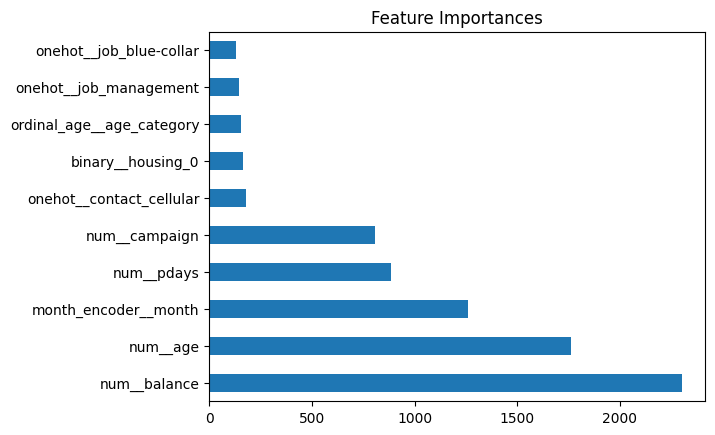

In [89]:
coef1 = pd.Series(best_model['model'].feature_importances_, transformer.get_feature_names_out()).sort_values(ascending = False).head(10)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

The data feature that is highly crucial is the `num_balance` (the amount of client's balance) followed by the `num_age` (the clients' age). These features contribute to the decision of how the deposit is made.

### Model Evaluation

**Confusion Matrix**

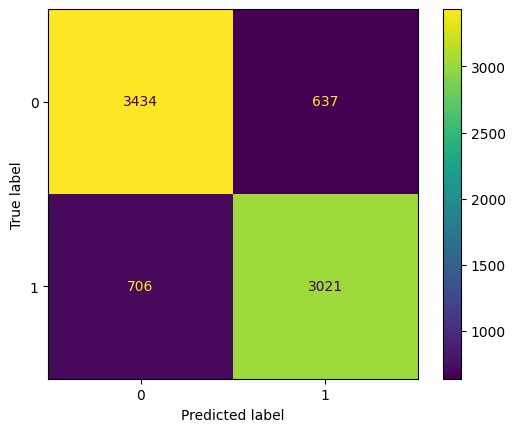

In [90]:
threshold = 0.429  
y_pred = (y_prob >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

- The model correctly identifies 3021 clients who will make a deposit, and correctly rejects 3434 clients who will not make a deposit (6455 correct predictions total).

- 637 clients are predicted to make a deposit but they actually do not make any deposits. (False positive)

- 706 clients are predicted not making deposits but they actually make a deposit. (False negative)

In [91]:
print("Accuracy", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy 0.8277763529110028
F1: 0.8181448882870683
Precision: 0.8258611262985238
Recall: 0.8105715052320902


We can interpret that this model has an overall good prediction towards the data.

### Rule-Based Targeting

In [101]:
train = X_train.join(y_train).sort_index()
train

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,age_category,balance_category,deposit
0,55,admin,1662,no,no,cellular,jun,2,-1,unknown,>50 y.o,2,1
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,36 - 50 y.o,5,1
2,51,admin,3025,no,no,cellular,may,1,352,other,>50 y.o,1,1
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,36 - 50 y.o,5,0
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,36 - 50 y.o,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7791,53,management,13901,yes,no,cellular,nov,1,-1,unknown,>50 y.o,1,0
7793,62,housemaid,2,no,no,cellular,nov,1,-1,unknown,>50 y.o,5,1
7795,36,unknown,179,no,no,cellular,aug,8,-1,unknown,36 - 50 y.o,4,0
7796,31,admin,54,yes,no,cellular,nov,1,-1,unknown,25 - 35 y.o,5,0


In [102]:
test = X_test.join(y_test).sort_index()
test

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,age_category,balance_category,deposit
0,55,admin,1662,no,no,cellular,jun,2,-1,unknown,>50 y.o,2,1
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,36 - 50 y.o,5,1
2,51,admin,3025,no,no,cellular,may,1,352,other,>50 y.o,1,1
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,36 - 50 y.o,5,0
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,36 - 50 y.o,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7793,62,housemaid,2,no,no,cellular,nov,1,-1,unknown,>50 y.o,5,1
7794,48,housemaid,5473,no,no,cellular,feb,2,184,success,36 - 50 y.o,1,1
7795,36,unknown,179,no,no,cellular,aug,8,-1,unknown,36 - 50 y.o,4,0
7796,31,admin,54,yes,no,cellular,nov,1,-1,unknown,25 - 35 y.o,5,0


In [103]:
group_job = train.groupby("job")["deposit"].value_counts(normalize=True).reset_index()
group_job = group_job[group_job["deposit"]==1].drop("deposit",axis=1)
group_job

,job,proportion
1,admin,0.470729
3,blue-collar,0.377888
5,entrepreneur,0.389671
7,housemaid,0.404908
8,management,0.512554
10,retired,0.679167
13,self-employed,0.438247
15,services,0.396907
16,student,0.755760
19,technician,0.455488


In [104]:
group_housing = train.groupby("housing")["deposit"].value_counts(normalize=True).reset_index()
group_housing = group_housing[group_housing["deposit"]==1].drop("deposit",axis=1)
group_housing

,housing,proportion
0,no,0.577047
3,yes,0.366798


In [105]:
group_loan = train.groupby("loan")["deposit"].value_counts(normalize=True).reset_index()
group_loan = group_loan[group_loan["deposit"]==1].drop("deposit",axis=1)
group_loan

,loan,proportion
0,no,0.501149
3,yes,0.325782


In [106]:
group_month = train.groupby("month")["deposit"].value_counts(normalize=True).reset_index()
group_month = group_month[group_month["deposit"]==1].drop("deposit",axis=1)
group_month

,month,proportion
0,apr,0.625624
3,aug,0.455108
4,dec,0.885246
6,feb,0.565678
9,jan,0.446078
11,jul,0.405319
13,jun,0.458122
14,mar,0.883333
17,may,0.333712
19,nov,0.433836


In [107]:
group_contact = train.groupby("contact")["deposit"].value_counts(normalize=True).reset_index()
group_contact = group_contact[group_contact["deposit"]==1].drop("deposit",axis=1)
group_contact

,contact,proportion
0,cellular,0.551130
2,telephone,0.502041
5,unknown,0.221173


In [109]:
group_age_category = train.groupby("age_category")["deposit"].value_counts(normalize=True).reset_index()
group_age_category = group_age_category[group_age_category["deposit"]==1].drop("deposit",axis=1)
group_age_category

C:\Users\Zea\AppData\Local\Temp\ipykernel_36916\957380485.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_age_category = train.groupby("age_category")["deposit"].value_counts(normalize=True).reset_index()


,age_category,proportion
0,<25 y.o,0.699275
3,25 - 35 y.o,0.479592
5,36 - 50 y.o,0.416393
6,>50 y.o,0.545220


In [110]:
group_balance_category = train.groupby("balance_category")["deposit"].value_counts(normalize=True).reset_index()
group_balance_category = group_balance_category[group_balance_category["deposit"]==1].drop("deposit",axis=1)
group_balance_category

C:\Users\Zea\AppData\Local\Temp\ipykernel_36916\48976513.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_balance_category = train.groupby("balance_category")["deposit"].value_counts(normalize=True).reset_index()


,balance_category,proportion
1,5,0.344017
3,4,0.452211
5,3,0.476529
6,2,0.523364
8,1,0.593220


In [111]:
group_poutcome = train.groupby("poutcome")["deposit"].value_counts(normalize=True).reset_index()
group_poutcome = group_poutcome[group_poutcome["deposit"]==1].drop("deposit",axis=1)
group_poutcome

,poutcome,proportion
0,failure,0.522021
2,other,0.593123
4,success,0.916422
7,unknown,0.406442


In [113]:
# Scorecard

# age_category
rule_based_train = pd.merge(train, group_age_category, on='age_category', how='inner').rename(columns={"proportion":"score_bin_age"})

# poutcome
rule_based_train = pd.merge(rule_based_train, group_poutcome, on='poutcome', how='inner').rename(columns={"proportion":"score_poutcome"})

# job
rule_based_train = pd.merge(rule_based_train, group_job, on='job', how='inner').rename(columns={"proportion":"score_job"})

# month
rule_based_train = pd.merge(rule_based_train, group_month, on='month', how='inner').rename(columns={"proportion":"score_month"})

# contact
rule_based_train = pd.merge(rule_based_train, group_contact, on='contact', how='inner').rename(columns={"proportion":"score_contact"})

# housing
rule_based_train = pd.merge(rule_based_train, group_housing, on='housing', how='inner').rename(columns={"proportion":"score_housing"})

# loan
rule_based_train = pd.merge(rule_based_train, group_loan, on='loan', how='inner').rename(columns={"proportion":"score_loan"})

# balance_category
rule_based_train = pd.merge(rule_based_train, group_balance_category, on='balance_category', how='inner').rename(columns={"proportion":"score_bin_balance"})

rule_based_train = rule_based_train.iloc[:,14:]
rule_based_train["total_score"] = rule_based_train.sum(axis=1)
rule_based_train

,score_poutcome,score_job,score_month,score_contact,score_housing,score_loan,score_bin_balance,total_score
0,0.406442,0.470729,0.458122,0.551130,0.577047,0.501149,0.523364,3.487983
1,0.406442,0.438247,0.625624,0.551130,0.366798,0.325782,0.344017,3.058039
2,0.593123,0.470729,0.333712,0.551130,0.577047,0.501149,0.593220,3.620110
3,0.406442,0.396907,0.333712,0.551130,0.366798,0.501149,0.344017,2.900154
4,0.406442,0.404908,0.433836,0.502041,0.366798,0.501149,0.452211,3.067384
...,...,...,...,...,...,...,...,...
7014,0.406442,0.512554,0.433836,0.551130,0.366798,0.501149,0.593220,3.365128
7015,0.406442,0.404908,0.433836,0.551130,0.577047,0.501149,0.344017,3.218529
7016,0.406442,0.510204,0.455108,0.551130,0.577047,0.501149,0.452211,3.453291
7017,0.406442,0.470729,0.433836,0.551130,0.366798,0.501149,0.344017,3.074100


In [114]:
# Score card

# age_category
rule_based_test = pd.merge(test, group_age_category, on='age_category', how='inner').rename(columns={"proportion":"score_age_category"})

# poutcome
rule_based_test = pd.merge(rule_based_test, group_poutcome, on='poutcome', how='inner').rename(columns={"proportion":"score_poutcome"})

# job
rule_based_test = pd.merge(rule_based_test, group_job, on='job', how='inner').rename(columns={"proportion":"score_job"})

# month
rule_based_test = pd.merge(rule_based_test, group_month, on='month', how='inner').rename(columns={"proportion":"score_month"})

# contact
rule_based_test = pd.merge(rule_based_test, group_contact, on='contact', how='inner').rename(columns={"proportion":"score_contact"})

# housing
rule_based_test = pd.merge(rule_based_test, group_housing, on='housing', how='inner').rename(columns={"proportion":"score_housing"})

# loan
rule_based_test = pd.merge(rule_based_test, group_loan, on='loan', how='inner').rename(columns={"proportion":"score_loan"})

# balance_category
rule_based_test = pd.merge(rule_based_test, group_balance_category, on='balance_category', how='inner').rename(columns={"proportion":"score_balance_category"})

rule_based_test = rule_based_test.iloc[:,14:]
rule_based_test["total_score"] = rule_based_test.sum(axis=1)
rule_based_test

,score_poutcome,score_job,score_month,score_contact,score_housing,score_loan,score_balance_category,total_score
0,0.406442,0.470729,0.458122,0.551130,0.577047,0.501149,0.523364,3.487983
1,0.406442,0.438247,0.625624,0.551130,0.366798,0.325782,0.344017,3.058039
2,0.593123,0.470729,0.333712,0.551130,0.577047,0.501149,0.593220,3.620110
3,0.406442,0.396907,0.333712,0.551130,0.366798,0.501149,0.344017,2.900154
4,0.406442,0.404908,0.433836,0.502041,0.366798,0.501149,0.452211,3.067384
...,...,...,...,...,...,...,...,...
7793,0.406442,0.404908,0.433836,0.551130,0.577047,0.501149,0.344017,3.218529
7794,0.916422,0.404908,0.565678,0.551130,0.577047,0.501149,0.593220,4.109555
7795,0.406442,0.510204,0.455108,0.551130,0.577047,0.501149,0.452211,3.453291
7796,0.406442,0.470729,0.433836,0.551130,0.366798,0.501149,0.344017,3.074100


In [117]:
rule_based_test["prediction"]=np.where(rule_based_test["total_score"] <= rule_based_train["total_score"].mean(),0,1)
rule_based_test

,score_poutcome,score_job,score_month,score_contact,score_housing,score_loan,score_balance_category,total_score,pred,prediction
0,0.406442,0.470729,0.458122,0.551130,0.577047,0.501149,0.523364,3.487983,1,1
1,0.406442,0.438247,0.625624,0.551130,0.366798,0.325782,0.344017,3.058039,0,0
2,0.593123,0.470729,0.333712,0.551130,0.577047,0.501149,0.593220,3.620110,1,1
3,0.406442,0.396907,0.333712,0.551130,0.366798,0.501149,0.344017,2.900154,0,0
4,0.406442,0.404908,0.433836,0.502041,0.366798,0.501149,0.452211,3.067384,0,0
...,...,...,...,...,...,...,...,...,...,...
7793,0.406442,0.404908,0.433836,0.551130,0.577047,0.501149,0.344017,3.218529,0,0
7794,0.916422,0.404908,0.565678,0.551130,0.577047,0.501149,0.593220,4.109555,1,1
7795,0.406442,0.510204,0.455108,0.551130,0.577047,0.501149,0.452211,3.453291,1,1
7796,0.406442,0.470729,0.433836,0.551130,0.366798,0.501149,0.344017,3.074100,0,0


In [118]:
f1_score(test["deposit"],rule_based_test["prediction"])

0.6744618655328195

In [119]:
cm_rulebased=pd.DataFrame({
    'actual': test["deposit"],
    'pred': rule_based_test["pred"]
}).value_counts().reset_index()

cm_rulebased

,actual,pred,count
0,0,0,2810
1,1,1,2538
2,0,1,1261
3,1,0,1189


### Cost Benefit Analysis

In [121]:
print("LightGBM Classification:")
print(classification_report(y_test, y_pred))

cm_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actual No", "Actual Yes"],
    columns=["Pred No", "Pred Yes"]
)
display(cm_df)

print("\n\nRule Based:")
print(classification_report(test["deposit"], rule_based_test["pred"]))

cm_rulebased_df = pd.DataFrame(
    confusion_matrix(test["deposit"], rule_based_test["pred"]),
    index=["Actual No", "Actual Yes"],
    columns=["Pred No", "Pred Yes"]
)
display(cm_rulebased_df)

LightGBM Classification:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      4071
           1       0.83      0.81      0.82      3727

    accuracy                           0.83      7798
   macro avg       0.83      0.83      0.83      7798
weighted avg       0.83      0.83      0.83      7798



,Pred No,Pred Yes
Actual No,3434,637
Actual Yes,706,3021




Rule Based:
              precision    recall  f1-score   support

           0       0.70      0.69      0.70      4071
           1       0.67      0.68      0.67      3727

    accuracy                           0.69      7798
   macro avg       0.69      0.69      0.69      7798
weighted avg       0.69      0.69      0.69      7798



,Pred No,Pred Yes
Actual No,2810,1261
Actual Yes,1189,2538


Let's assume that the:

- average deposit value is $1,000,

- cost per marketing product is $2 per customer.

**Comparison between rule-based model and LightGBM model**

*Deposit Fund Entry*: (True Positive)

- Rule-based: $1,000 x 2538 = $2,538,000

- LightGBM: $1,000 x 3021 = $3,021,000

*Opportunity Cost*: (False Negative)

- Rule-based: $1,000 x 1189 = $1,189,000

- LightGBM: $1,000 x 706 = $706,000

*Wasted Cost*: (False Positive)

- Rule-based: $2 x 1261 = $2,522

- LightGBM: $2 x 637 = $1,274

From this cost benefit analysis, we know that using LightGBM model can positively increase the deposit by **19.03%**, minimize the opportunity cost by **40.62%**, and reduce the wasted cost by **49.48%**.

### Conclusion

The tuned LightGBM classification model demonstrates strong and reliable performance in predicting customers who are likely to subscribe to term deposit products at Bank A. With an **accuracy of 85%** and **a weighted F1-score of 0.83**, the model effectively balances precision and recall, ensuring that potential deposit customers are identified accurately while minimizing unnecessary marketing efforts. Compared to the default model, the tuned version shows clear improvements in identifying true positive customers and reducing misclassification, indicating better generalization and robustness. 

Overall, this model provides a practical and data-driven solution that can support targeted marketing campaigns, improve resource allocation, and enhance customer acquisition strategies when deployed in a real business environment.

*Key Takeaways*

Based on the selected LightGBM model, several key features were identified as having the strongest influence on the model’s ability to predict a client's likelihood of making a deposit in future marketing campaigns:

1. Successful outcomes from previous marketing campaigns positively increase a client's likelihood of making a deposit in subsequent campaigns.

2. Prospective clients without a housing loan show a higher tendency to place deposits.

3. Clients who have not been contacted for a long period since the last campaign exhibit a higher likelihood of making a deposit.

4. Higher account balance levels are associated with an increased likelihood of clients making a deposit.

5. Clients who do not have personal loans are more inclined to make a deposit.

6. Prospective clients who are students or retirees show a higher tendency to place deposits.

7. Lists of prospective clients who have never been contacted before tend to have a lower likelihood of making a deposit.

8. More frequent contact attempts are associated with a decreased likelihood of clients making a deposit.

### Recommedation

1. Data Recommendations

    - More comprehensive demographic attributes, such as education level, detailed employment categories, or income segments.

    - More detailed customer interaction history, such as response time to previous calls or messages, call duration, and communication channels used (phone, email, SMS).

2. Model Recommendations

    - Explore advanced ensemble techniques, including stacking or blending multiple high-performing models (Random Forest, LightGBM, CatBoost).

3. Business Recommendations

    - The model should primarily be used by **Marketing and Business Development teams** as a decision-support tool, and **Customer Relationship Management (CRM) teams** to prioritize prospective customers.

    - The model is recommended to be retrained every **3–6 months**, depending on the changes in customer behavior, new marketing strategies, and economic conditions or regulatory updates.

    - The model is most effectively used:
     
        - Before marketing campaigns begin, to create a prioritized list of potential customers.

        - During campaigns, to evaluate performance and adjust outreach strategies.

        - After campaigns, to analyze results and extract insights for future initiatives.

### Saving Final Model

In [92]:
model_X = pd.concat([X_train,X_test])
model_X

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,age_category,balance_category
0,55,admin,1662,no,no,cellular,jun,2,-1,unknown,>50 y.o,2
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,36 - 50 y.o,5
2,51,admin,3025,no,no,cellular,may,1,352,other,>50 y.o,1
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,36 - 50 y.o,5
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,36 - 50 y.o,4
...,...,...,...,...,...,...,...,...,...,...,...,...
7793,62,housemaid,2,no,no,cellular,nov,1,-1,unknown,>50 y.o,5
7794,48,housemaid,5473,no,no,cellular,feb,2,184,success,36 - 50 y.o,1
7795,36,unknown,179,no,no,cellular,aug,8,-1,unknown,36 - 50 y.o,4
7796,31,admin,54,yes,no,cellular,nov,1,-1,unknown,25 - 35 y.o,5


In [93]:
model_y = pd.concat([Y_train,y_test])
model_y

0       1
1       1
2       1
3       0
4       0
       ..
7793    1
7794    1
7795    0
7796    0
7797    1
Name: deposit, Length: 14817, dtype: int64

In [94]:
best_estimator = final_estimator

best_estimator.fit(model_X,model_y)

[LightGBM] [Info] Number of positive: 7082, number of negative: 7735
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 14817, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477965 -> initscore=-0.088199
[LightGBM] [Info] Start training from score -0.088199


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('binary', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [97]:
import pickle

filename = 'Model Final.sav'

pickle.dump(best_estimator, open(filename, 'wb'))

deposit_test = pd.read_csv('bank_marketing_campaign_cleaned.csv')

filename = 'Model Final.sav'
loaded_model = pickle.load(open(filename, 'rb'))